# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


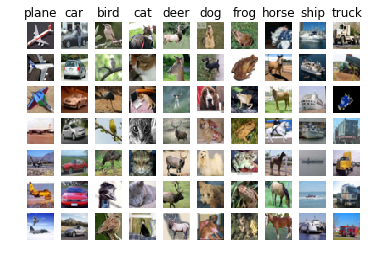

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [189]:
np.flatnonzero(y_train == y)

array([   29,    30,    35, ..., 48978, 48979, 48986])

range(0, 1000)

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


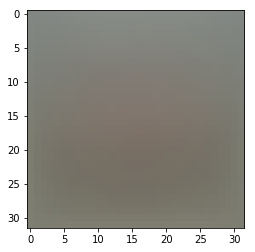

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0) # axis = 0 
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

3072

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [25]:
X_train

array([[ -71.64189796,  -73.98173469,  -69.47391837, ...,   -3.64218367,
         -33.86195918,  -42.39957143],
       [  23.35810204,   41.01826531,   54.52608163, ...,   16.35781633,
           7.13804082,   29.60042857],
       [ 124.35810204,  119.01826531,  122.52608163, ...,  -46.64218367,
         -39.86195918,  -30.39957143],
       ...,
       [ -69.64189796,  -62.98173469,  -56.47391837, ...,   57.35781633,
          34.13804082,    2.60042857],
       [-120.64189796, -131.98173469, -118.47391837, ...,   48.35781633,
          48.13804082,   90.60042857],
       [  44.35810204,   57.01826531,   96.52608163, ...,  -35.64218367,
         -47.86195918,  -24.39957143]])

In [27]:
X_train[0]

array([-71.64189796, -73.98173469, -69.47391837, ...,  -3.64218367,
       -33.86195918, -42.39957143])

In [29]:
len(X_train)

49000

In [30]:
len(X_train[0])

3072

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.326356


In [86]:
X_dev.shape

(500, 3073)

In [87]:
score.shape

(500, 10)

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -2.044959 analytic: -2.044959, relative error: 1.030517e-10
numerical: 22.280891 analytic: 22.280891, relative error: 1.038792e-11
numerical: 35.222087 analytic: 35.222087, relative error: 2.977567e-13
numerical: -39.735143 analytic: -39.735143, relative error: 1.045210e-11
numerical: -6.140123 analytic: -6.140123, relative error: 7.228962e-13
numerical: -42.998296 analytic: -42.998296, relative error: 9.488270e-12
numerical: 34.308652 analytic: 34.317445, relative error: 1.281347e-04
numerical: 26.453841 analytic: 26.453841, relative error: 1.008959e-11
numerical: 13.383414 analytic: 13.383414, relative error: 3.360553e-11
numerical: -13.296117 analytic: -13.305765, relative error: 3.627016e-04
numerical: -1.947453 analytic: -1.947693, relative error: 6.172460e-05
numerical: -3.051923 analytic: -3.051870, relative error: 8.584938e-06
numerical: 5.909800 analytic: 5.940794, relative error: 2.615361e-03
numerical: -26.255505 analytic: -26.252193, relative error: 6.307090e-05


In [11]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized
binary, row_sum,npnum_train,y0= svm_loss_vectorized(W, X_dev, y_dev, 0.000005)


ValueError: not enough values to unpack (expected 4, got 2)

In [179]:
binary[npnum_train,y0]

(1, 500)

In [180]:
binary.shape

(500, 10)

In [176]:
binary

matrix([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 0.],
        ...,
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 0., 1., ..., 1., 1., 1.]])

In [169]:
a = np.ones((10,1))
b = np.ones((1,10))*3

In [184]:
binary

matrix([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 0.],
        ...,
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        [1., 0., 1., ..., 1., 1., 1.]])

In [115]:
score.shape

(500, 10)

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.326356e+00 computed in 0.106818s
Vectorized loss: 9.326356e+00 computed in 0.007724s
difference: 0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.106402s
Vectorized loss and gradient: computed in 0.008106s
difference: 0.000000


In [190]:
np.random.choice(range(num_train),size = batch_size, replace =True)

NameError: name 'num_train' is not defined

In [197]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
loss_history = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)


iteration 0 / 1500: loss 407.253607
iteration 100 / 1500: loss 242.527020
iteration 200 / 1500: loss 146.909661
iteration 300 / 1500: loss 90.949911
iteration 400 / 1500: loss 57.079370
iteration 500 / 1500: loss 35.717406
iteration 600 / 1500: loss 24.070652
iteration 700 / 1500: loss 16.578953
iteration 800 / 1500: loss 11.625207
iteration 900 / 1500: loss 8.862659
iteration 1000 / 1500: loss 7.406849
iteration 1100 / 1500: loss 5.847578
iteration 1200 / 1500: loss 6.012629
iteration 1300 / 1500: loss 5.853860
iteration 1400 / 1500: loss 4.870178


In [194]:
X_batch.shape

(200, 3073)

In [195]:
y_batch.shape

(200,)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [15]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=5000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 5000: loss 408.797601
iteration 100 / 5000: loss 241.519049
iteration 200 / 5000: loss 147.226195
iteration 300 / 5000: loss 90.568306
iteration 400 / 5000: loss 56.319102
iteration 500 / 5000: loss 35.465382
iteration 600 / 5000: loss 23.791847
iteration 700 / 5000: loss 15.980444
iteration 800 / 5000: loss 11.527780
iteration 900 / 5000: loss 9.232153
iteration 1000 / 5000: loss 7.581845
iteration 1100 / 5000: loss 6.525428
iteration 1200 / 5000: loss 5.769664
iteration 1300 / 5000: loss 6.204538
iteration 1400 / 5000: loss 4.810902
iteration 1500 / 5000: loss 4.772862
iteration 1600 / 5000: loss 4.998171
iteration 1700 / 5000: loss 5.206980
iteration 1800 / 5000: loss 4.505792
iteration 1900 / 5000: loss 5.260625
iteration 2000 / 5000: loss 5.183574
iteration 2100 / 5000: loss 5.168937
iteration 2200 / 5000: loss 4.659158
iteration 2300 / 5000: loss 4.815917
iteration 2400 / 5000: loss 4.623948
iteration 2500 / 5000: loss 4.843021
iteration 2600 / 5000: loss 4.624875
i

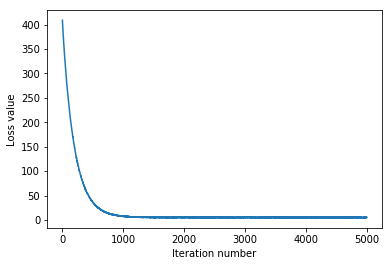

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [220]:
y_pred = svm.predict(X_train)

In [222]:
y_pred.shape

(49000,)

In [229]:
X_train.shape

(49000, 3073)

In [230]:
X_test.shape

(1000, 3073)

In [17]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379633
validation accuracy: 0.382000


In [2]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
for i in np.array_split(X_train, num_folds):
    X_train_folds.append(i)
for i in np.array_split(y_train, num_folds):
    y_train_folds.append(i)
    
k_to_accuracies = {}
for k in k_choices:
    accuracy=[]
    for X_folder, y_folder in zip(X_train_folds,y_train_folds): 
        X_test_set = X_folder
        y_test_set = y_folder
        X_train_set = np.array([item for s in X_train_folds if s is not X_test_set for item in s])
        y_train_set = np.array([item for s in y_train_folds if s is not y_test_set for item in s])
        classifier = KNearestNeighbor()
        classifier.train(X_train_set, y_train_set)
        dists = classifier.compute_distances_no_loops(X_test_set)
        C_y_test_pred = classifier.predict_labels(dists, k=k)
        num_correct = np.sum(C_y_test_pred == y_test_set)
        accuracy.append(float(num_correct) / num_test)
    k_to_accuracies[k]=accuracy


#for k in k_choices:
#  for X_folder, y_folder in zip(X_train_folds,y_train_folds):
#    print(X_folder,y_folder)

NameError: name 'np' is not defined

In [232]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
    
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(learning_rate,regularization_strength)] = (train_accuracy, val_accuracy)





# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 402.574476
iteration 100 / 1500: loss 239.687322
iteration 200 / 1500: loss 146.691928
iteration 300 / 1500: loss 90.082107
iteration 400 / 1500: loss 56.145283
iteration 500 / 1500: loss 36.553503
iteration 600 / 1500: loss 23.724029
iteration 700 / 1500: loss 16.599607
iteration 800 / 1500: loss 11.419800
iteration 900 / 1500: loss 9.568499
iteration 1000 / 1500: loss 7.549092
iteration 1100 / 1500: loss 6.671700
iteration 1200 / 1500: loss 6.222491
iteration 1300 / 1500: loss 5.121296
iteration 1400 / 1500: loss 4.949813
iteration 0 / 1500: loss 794.717370
iteration 100 / 1500: loss 288.607090
iteration 200 / 1500: loss 108.650423
iteration 300 / 1500: loss 42.920729
iteration 400 / 1500: loss 19.581234
iteration 500 / 1500: loss 10.348395
iteration 600 / 1500: loss 7.316422
iteration 700 / 1500: loss 5.892587
iteration 800 / 1500: loss 5.802906
iteration 900 / 1500: loss 5.095606
iteration 1000 / 1500: loss 5.301303
iteration 1100 / 1500: loss 5.158310
iter

/Users/richard/assignment1/cs231n/classifiers/linear_svm.py:80: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
/Users/richard/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/richard/assignment1/cs231n/classifiers/linear_svm.py:80: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.377959 val accuracy: 0.368000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.364918 val accuracy: 0.383000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.125306 val accuracy: 0.112000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.054592 val accuracy: 0.057000
best validation accuracy achieved during cross-validation: 0.383000


In [1]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

NameError: name 'results' is not defined

In [234]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.363000


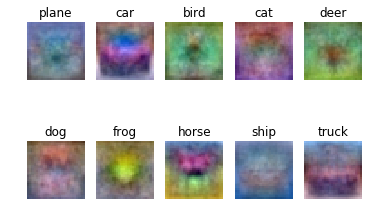

In [235]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*